# Predicting the failure rate of Kickstarter projects

#### David Collins, Nathan Rosenberg

## Table of Contents <br>

_put table of contents here_

Rough outline:

Intro - David
 * background
 * packages and stuff

Data Wrangling - David

EDA
 * Plot graphs for 
 * which category of project is the most successful - David
     * take top 1 or 2 most successful categories of projects and graph which are the most successful within the sub-category
 * length of campaign vs failure rate
 * montary goal vs failure rate
 * see which factor has the highest correlation using multiple regression with both scikit-learn and statsmodels - David
 * build model to predict success or failure given these factors

Conclusion

# 1. Introduction

Something about what kickstarter is, about how theres a spread of projects failing or succeeding and we want to see what some potential causes for failed kickstarter projects may be, if there are any, using dataset taken from kaggle

Idk some basic bullshit

## Necessary Packages and Other Resources

Mention kaggle, links to documentation, used dataset 'ks-projects-201801.csv' because it contained more up to date data

Link to dataset https://www.kaggle.com/kemical/kickstarter-projects/data#ks-projects-201801.csv

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime as dt

Used latin-1 encoding because utf-8 can't encode certain characters (\x99 byte) in the CSV

In [48]:
# Read all of data from CSV file into a pandas dataframe
k_d = pd.read_csv('data.csv', encoding = 'latin-1')

k_d.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Look at the different types of states

In [49]:
print(k_d['state'].unique())

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


Drop undefined and live since they can't necessarily be judged, consider failed, cancelled and suspended all failures

In [50]:
# Removing all the rows that have the state of undefined or live
k_d = k_d[k_d['state'] != 'undefined']
k_d = k_d[k_d['state'] != 'live']

# Add a column to the end of the dataframe and tag each row whether it was a success or failure 
# 1 = success, 0 = failure
k_d["successful"] = 0
k_d.loc[k_d['state'] == 'successful', 'successful'] = 1

k_d.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0


# Data Exploration and Analysis

## Overall Failure Rates

In [51]:
failure_rate = k_d.groupby('successful')['successful'].count()
failure_rate

successful
0    238344
1    133956
Name: successful, dtype: int64

## Category Breakdown

In [52]:
category_totals = k_d.groupby('main_category')['main_category'].count()
total_entries = len(k_d)



## Campaign length vs Failure Rate

Another possible predictor of failure rate is campaign length, so we'd like to see if we should explore a relationship between campaign length and failure rate. Since our dataset only gives us the launch date and deadline in string format, in order to get a quantitative campaign length we converted the launch date and deadline into datetime objects, found the difference between them, and added a new column for campaign length.

In [98]:
#Create a new column for campaign length
k_d['campaign_length'] = 0
#For each row convert the launch date and deadline into datetime objects, then set the campaign length to the difference
#between the two
for i, row in k_d.iterrows():
    deadline = dt.strptime(row['deadline'], '%Y-%m-%d')
    launched = dt.strptime(row['launched'], '%Y-%m-%d %H:%M:%S')
    k_d.at[i, 'campaign_length'] = int((deadline - launched).days)
k_d.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,successful,campaign length(days),length_group,campaign_length
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,58,1,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,59,1,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,44,1,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,29,1,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,55,1,55


In order to get a useful visual representation of the campaign length vs failure rate, we decided to split the dataset into bins based on campaign length, so that we could compare the failure rates of each bin and try to find a relationship between each bin's campaign length group and failure rate. We did our best to group them with even amounts of data points in each bin, with about 40,000 entries in each bin, however campaigns with a duration of 28 days are so common that they need their own bin, and still have more than triple the data points that the other bins have. Because there is no point in analyzing data points with the same campaign length seperately, we will move forward with all the bins being about even size except the 28 days bin, and will keep in mind the extra data points in that bin when we analyze the results.

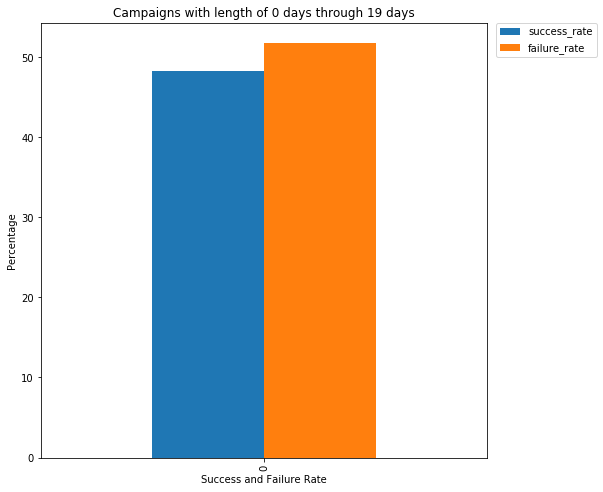

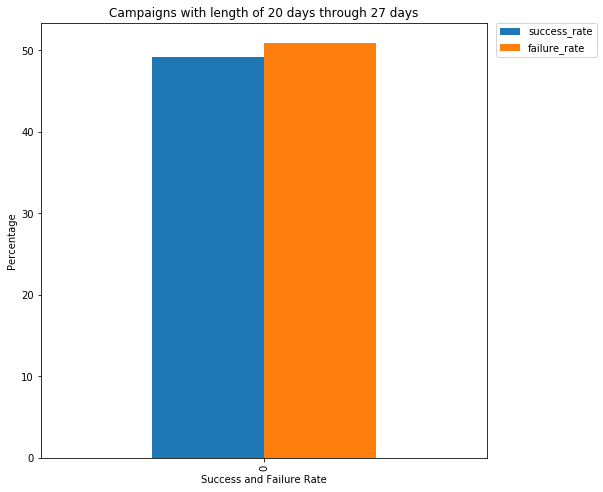

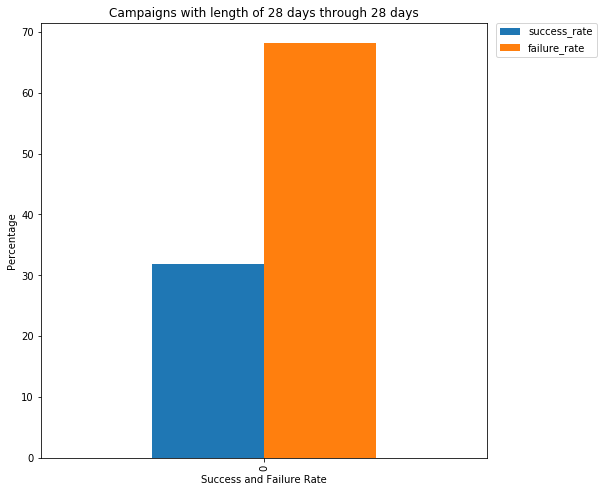

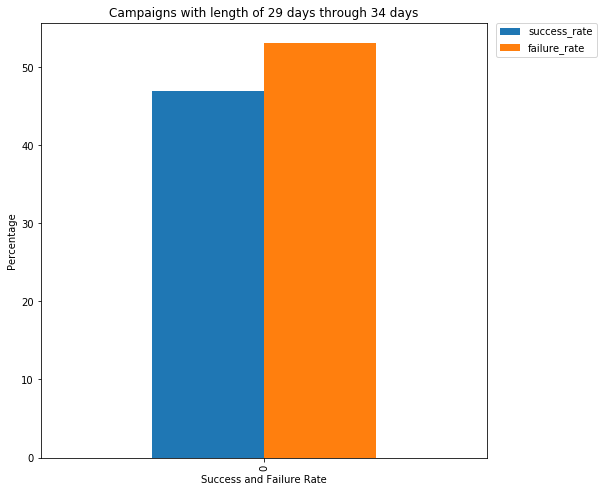

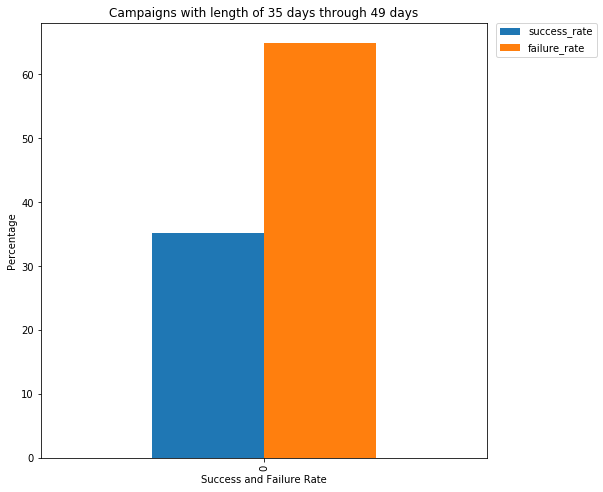

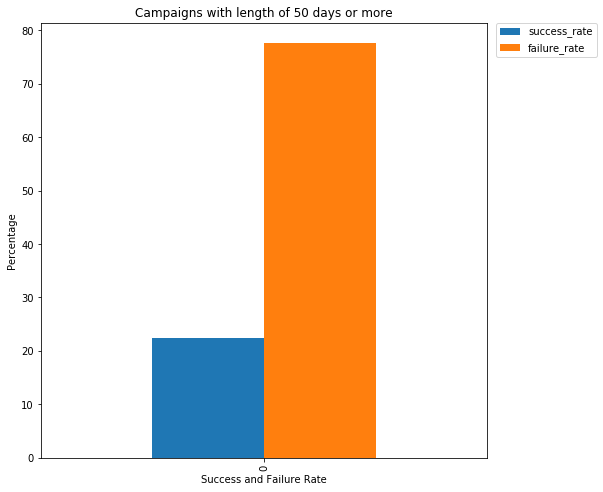

In [255]:
#Give each data point a bin ID based on their assigned bin
length_groups = pd.DataFrame(k_d)
length_bins = [0, 20, 28, 29, 35, 50, 100000]
length_groups['length_group'] = pd.cut(k_d.campaign_length, length_bins, labels=['1','2','3','4','5','6'])

#Iterate through for each bin ID
for i in range(1,7):
    #Create a new dataframe containing only the data points with the bin ID we are currently plotting
    lg = pd.DataFrame(length_groups[length_groups['length_group'] == str(i)])
    #Get the successrate by diving the number of successful data points by the total number of data points
    success_rate = lg['successful'].sum()/lg['ID'].count()
    #Create a new dataframe containing only the success and failure rate
    d = {'success_rate': [success_rate*100], 'failure_rate': [(1-success_rate)*100]}
    sf = pd.DataFrame(d)
    #Plot the success and failure rate on a bar graph
    if i != 6:
        title = 'Campaigns with length of ' + str(length_bins[i-1]) + ' days through ' + str(length_bins[i]-1) + ' days'
    else:
        title = 'Campaigns with length of ' + str(length_bins[i-1]) + ' days or more'
    ax = sf[['success_rate', 'failure_rate']].plot(kind='bar', figsize=(8,8), title=title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
    ax.set_xlabel('Success and Failure Rate')
    ax.set_ylabel('Percentage')

So from this representation we can see that for the bins of 0-19, 20-27, and 29-34, the failure rate is similar at a little over 50% for each bin. This makes sense because we would expect that on average about half of the Kickstarters would fail and half would succeed. But the other bins failure rates are a little more interesting. Looking at just the 35-49 and 50+ bins, we can see that the failure rates in these bins are much higher than the previoous bins, suggesting that Kickstartes with campaign lengths of >35 have a much higher chance to fail then campaigns with lengths <35, with that chance to fail increasing even more for campaigns with lengths of >50.

However, we have to take all the assumptions we've made so far with a grain of salt, because if we look at the failure rate for campaigns with a length of 28 days, we can see that it is substantially higher than we would expect, with a failure rate of about 68%. Based on the sheer number of Kickstarters in this bin we should get a more accurate average failure rate, so this could mean that the actual average failure rate of all Kickstarters should be closer to this bin's failure rate, and all the other bins are innacurate.

Regardless of whether the unexpectedly high failure rate of Kickstarters with a length of 28 days is indicative of innaccuracies in the other bins, it appears to be safe to say that if you want your Kickstarter to be successful, you probably have a better shot by limiting your campaign to less than 35 days, and if you really want the best results it seems that a length of 20-27 days has highest rate of success.

## Monetary Goal vs Failure Rate

Another possible predictor of failure rate is the monetary goal for the campaign, so we would like to see if we should look into a relationship between monetary goal and failure rate. 

In order to do this we decided to take a similar approach to analyzing campaign lenght vs failure rate, by splitting up the dataset into equally sized bins of monetary goal ranges, and comparing the average failure rates of each bin to see if we can find a relationship between monetary goal and failure rate.

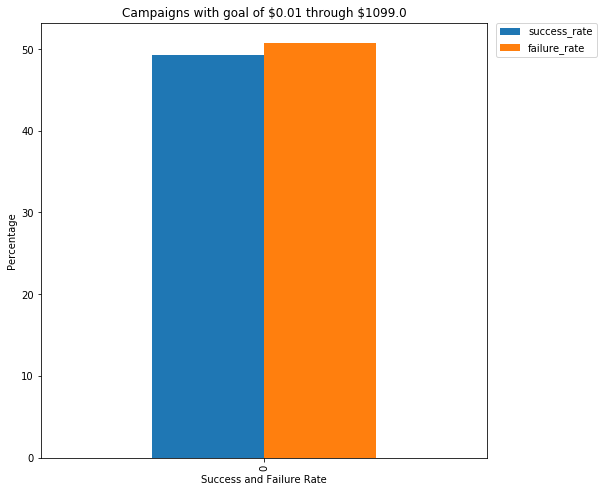

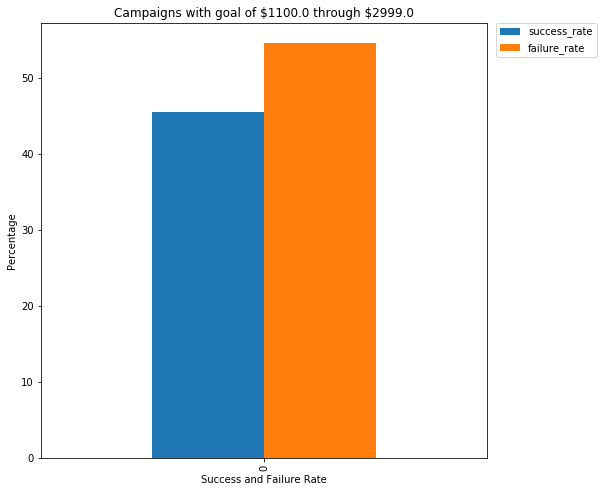

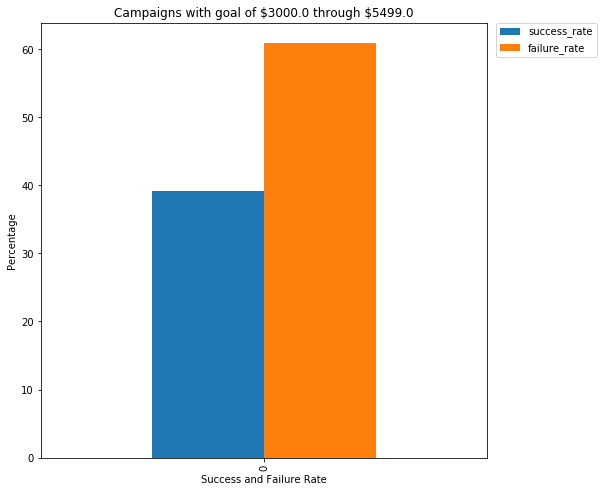

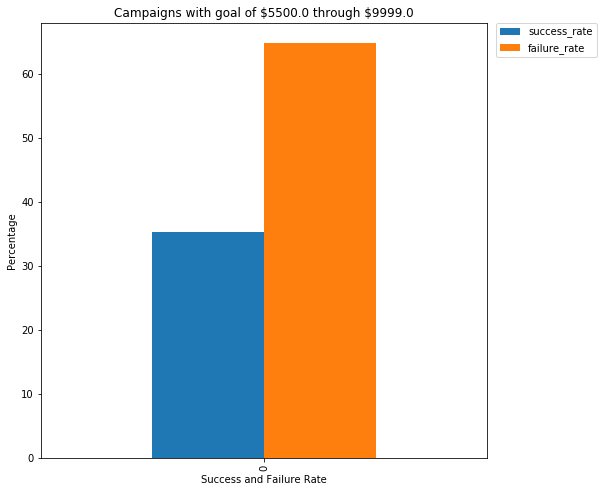

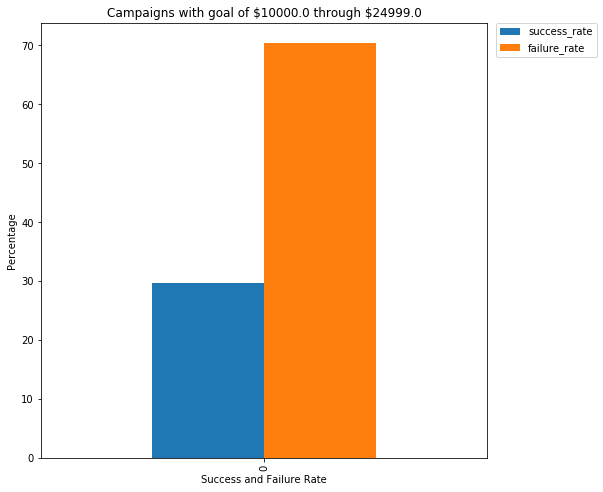

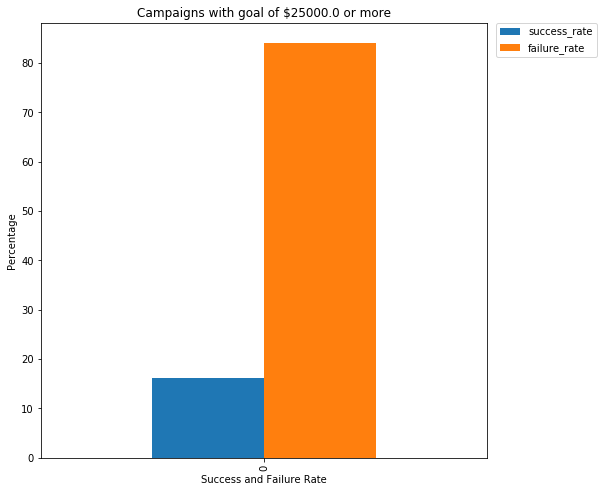

In [264]:
#Give each data point a bin ID based on their assigned bin
money_groups = pd.DataFrame(k_d)
#Get the bin range created by evenly populated bins
s, money_bins = pd.qcut(k_d.usd_goal_real, q=6, labels=['1','2','3','4','5','6'], retbins=True)
money_groups['money_group'] = pd.qcut(k_d.usd_goal_real, q=6, labels=['1','2','3','4','5','6'])

# #Iterate through for each bin ID
for i in range(1,7):
#     #Create a new dataframe containing only the data points with the bin ID we are currently plotting
    lg = pd.DataFrame(money_groups[money_groups['money_group'] == str(i)])
#     #Get the successrate by diving the number of successful data points by the total number of data points
    a = lg['ID'].count()
    success_rate = lg['successful'].sum()/lg['ID'].count()
    #Create a new dataframe containing only the success and failure rate
    d = {'success_rate': [success_rate*100], 'failure_rate': [(1-success_rate)*100]}
    sf = pd.DataFrame(d)
    #Plot the success and failure rate on a bar graph
    if i != 6:
        title = 'Campaigns with goal of \$' + str(money_bins[i-1]) + ' through \$' + str(money_bins[i]-1)
    else:
        title = 'Campaigns with goal of \$' + str(money_bins[i-1]) + ' or more'
    ax = sf[['success_rate', 'failure_rate']].plot(kind='bar', figsize=(8,8), title=title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
    ax.set_xlabel('Success and Failure Rate')
    ax.set_ylabel('Percentage')

Here we can see a clear relationship between monetary goal and failure rate. Looking at the first graph, we see about a 50\% failure rate for Kickstarters with a goal of \\$0.01 to \\$1099. This failure rate increases almost linearly by about 5% for each bin as we increase the monetary goal, with a small jump at the final bin of campaigns with a goal of \\$25,000 or more having a failure rate of more than 80\%. If we think about it this makes sense, as we would expect a lower monetary goal to be more easily attainable, and therefore have a lower failure rate. So from this visualization we can see that monetary goal may be a great candidate for prediciting whether a Kickstarter will fail or succeed.